<h1 style="text-align:center;">Quantifying Acne Severity Dynamics - A Bayesian and KL Divergence Framework</h1>
<p style="text-align:center;">By Nathaniel Wolff.</p>



# Analysis Structure and Results

Dataset is found here: https://www.kaggle.com/datasets/manuelhettich/acne04. Consists of n = 10 synthetic patients, 
with acne severity recorded over 112 distinct days of treatment (each indexing a distinct treatment history).


### Analysis Steps
#### 1) Data Parsing -
Base dataframe is seperated by patient. Raw acne severities are normalized as % change relative to patient average baseline intensity.

#### 2) Treatment History Metadata Addition - 
A treatment history metadata column is added to each patient dataframe. Histories are of the form ( (Treatment $a_{1}$, Day 1),...(Treatment $a_{n}$, Day i)), where n is the index of a given treatment in the full history.

#### 3) Kernel Density Estimation of normalized acne severity change -
Over all patient dataframes, the distribution of normalized acne severity over all histories and patients is obtained, and a Kernel Density Estimate is fit.

#### 4) Optimization of KDE and Discretization of Acne Severity Change into 3 states -
The KDE is optimized for local maxima and saddle points; corresponding quantiles define an acne severity change states.  
*In progress: dynamic decision of state number.*

#### 5) Validation of Discretization via Quantile Bootstrapping -
Before binning normalized acne severities into change states, the robustness of binning is assessed via bootstrapping of each quantile. 

#### 6) Calculation of Acne Severity Change State Distribution Series over treatment sequence - 
With an uninformative Dirhclet prior and multinomial likelihood,  posterior distributions of acne severity change states are calculated for each treatment history. 

#### 7) Calculation of information cost between consecutive distributions - 
Kullback-Leibler divergence is calculated between consecutive treatment history posteriors. Cumulative KL divergence represents the information cost of not updating distribution from day to day, a descriptor of distance between distributions. 

#### 8) Determination of Diminishing Returns: Fitting of Univariate Spline to Cumulative KL divergence curve - 
A univariate spline curve is fit to the cumulative KL Divergence of the entire treatment series. The curve's first derivative is evaluated against a threshold ("p value"), returning sections of non-diminishing returns in treatment. 

#### 9) Fitting of Linear Model to Non-Diminishing Treatment Returns' Cumulative KL Divergence
A linear regression model is fit to each non-diminishing return section. Histories are plotted on the x-axis. The systems biology/biochemical implications of these sections are used to determine the form of the predictive model below.


# Model Structure and Parameter Estimation


### Latent State and Associated Evolution
The inferred Latent State Vector is  $v_{t} = \begin{pmatrix}B_t & I_t & S_t\end{pmatrix}^{T}$, where $B_t$, $I_t$, and $S_t$ refers to bacterial presence, inflammatory activity, and sebum production, respectively, at time t. The components evolve according to the following vector-valued function, $v_{t} = F_{\theta}(v_{t-1}, u_{t-1}; \theta) + w_{t}$: 

$
\begin{array}{lcc}
\text{Component} & \text{Equation} \\
\hline
B_{t} & B_{t-1} + r_{growth} \cdot B_{t-1}\frac{1-B_{t-1}}{K_{CC}}-k_{antibiotics} \cdot days_{antibiotics} \cdot B_{t-1} + k_{sebum} \cdot B_{t-1} \cdot S_{t-1} + noise \\
I_{t} & I_{t-1} + I_{bacterial \, induction} \cdot B_{t-1} - I_{decay}/T(tstd)\cdot T(tstd) - I_{baseline decay} \cdot I_{t-1} + noise \\
S_{t} & S_{t-1} + r_{I production} \cdot I_{t-1} -r_{cream \, clean} \cdot cream \, used + noise
\end{array}
$

Where $r_{growth}$ refers to the growth constant of acne causing bacteria, $K_{CC}$ refers to their carrying capacity, $k_{antibiotics}$ refers to the antibiotic's action rate constant, $k_{sebum}$ refers to the action constant of sebum increasing bacterial load, $I_{bacterial \, induction}$ refers to the rate of inflammation induced by bacterial load, $I_{decay}/tstd$ refers to the proportionality constant between inflammation reduction and cumulative treatment effect, $T(tstd)$. $r_{I production}$ refers to the rate of inflammation increase given active inflammation, $r_{cream \, clean}$ refers to the amount of mechanical sebum removal that the cream causes. 

$T(tstd)$ refers to the cumulative treatment effect of a given treatment history (referred to here as treatment series to date, tstd). $T(tstd)$ is calculated as the expected acne severity change over the Dirichlet posterior distribution corresponding to the last day in the treatment series to date, that is: $T(tstd) = \mathbb{E}(\Delta Severity \mid tstd)$  

<br>
<br>

### Mapping from Latent State to Acne Severity Change State Probability


Here, the probability distribution of Acne Severity Change State (Low, Medium, and High) is a categorical distribution given by an affine function of $v_t$, that is, $Pr(Acne\,\,Severity\,\,Change\,\,State_{t} \mid v_{t}) = softmax(Wv_{t} + b)$ = 
$softmax(\begin{pmatrix} w_{B,\,S1} & w_{I,\,S1} & w_{S,\,S1} \\\\ w_{B,\,S2} & w_{I,\,S2} & w_{B,\,S2} \\\\ w_{B,\,S3} & w_{I,\,S3} & w_{B,\,S3} \end{pmatrix} \cdot \begin{pmatrix} B_{t} \\ I_{t} \\ S_{t} \end{pmatrix} + \begin{pmatrix} b_{S1} \\ b_{S2} \\ b_{S3} \end{pmatrix})$
$$ $$
Here, $W$ refers to a 3x3 matrix, whose ijth entry is the corresponding weight, and $B$ refers to a 1x3, whose jth entry refers to the corresponding biases below.
<br>
<br>

### Expectation-Maximization of Model Parameters and Latent State Acne Severity Change State Distribution
 

As with typical Hard EM algorithms, this implementation maximizes a log-likelihood function. We posit that the observed acne severity change change Dirichlet distribution for history t is generated by: 
1) A latent state trajectory: the set of all latent state vectors over all histories up to t.  
2) An an underlying mapping from latent state to probabilities of each acne severity change state being realized (see above).

The likelihood to be maximized for $\theta$ is the probability of realizing the observed series of Dirichlet distributions, that is: $L(\theta, W, b,\{{v}_{t},\}_{t=1}^T) = Pr(\{Dir(\alpha_{t}),\}_{t=1}^T) \mid \theta, W, b, \{v_{t},\}_{t=1}^T)$. 

where $\{\hat {v}_{t}\}_{t=1}^T$ is the sequence of inferred latent biological states (latent trajectory). Since exact marginalization over all latent trajectories is intractable, we instead adopt a Hard EM/MAP approximation. Here, the latent trajectory is replaced by its most probable realization under a biologically constrainted prior, that is, $\{\hat {v}_{t}\}_{t=1}^T$. 

Here, $\{\hat {v}_{t}\}_{t=1}^T$ is $arg max [Pr(\{Dir(\alpha_{t}),\}_{t=1}^T) \mid \theta, W, b, \{v_{t}\}_{t=1}^T)] \cdot \pi (\{v_{t},\}_{t=1}^T$, where $\pi (\{v_{t},\}_{t=1}^T)$ is a generative prior distribution over latent trajectories, set with biological constraints. In this implementation, the prior is enforced through the state evolution equations and Gaussian process noise, instead of being directly defined.  


In log space, the likelihood evaluated at $\{\hat {v}_{t}\}_{t=1}^T$ is estimated via the following expression: $\hat{\mathcal{L}}(\theta) =\sum_{t=1}^{T} \Bigg[ \sum_{i=1}^{K} \frac{\alpha_{t,i}}{\sum_j \alpha_{t,j}} \log \hat{p}_{t,i}(\{v_t\}_{t=1}^T, \theta) - \frac{1}{2} (\mathbf{v}_t - F_{\theta}(\mathbf{v}_{t-1}, \theta))^\top Q^{-1} (\mathbf{v}_t - F_{\theta}(\mathbf{v}_{t-1}, \theta)) - \frac{1}{2} \log \det Q+ \log \pi(\theta)
\Bigg]$, where Q is a small process covariance matrix and $\pi(\theta)$ is a prior distribution over all model parameters. 

This likelihood is maximized analytically using the process below. 



$$\textbf{Maximization of Parameters}$$

The maximization step maximizes both the weights/biases and the model parameters (that is, $\theta$). Since there is no closed form for the likelihood of the data given the existing weights $ L(Acne\,\,Severity\,\,Change\,\,State \mid W_{i}, B_{i})$, the model maximizes it with gradient ascent, according to the following gradient formulations:
$$\frac{\partial L}{\partial W} = \sum_{i=1}^{number\,of\,histories} (Pr(Low, Medium, High \mid v_{t}) - Pr(Low, Medium, High)_{k})v_{k}$$
and $$\frac{\partial L}{\partial B} = \sum_{i=1}^{number\,of\,histories} (Pr(Low, Medium, High \mid v_{t}) - Pr(Low, Medium, High)_{k})$$

In the case of the model parameters $(\theta)$, each of them are optimized via typical Ordinary Least Squares, that is, 
$\hat{\theta_{k}} = (X^{T}X)^{-1}X^{T}Y$, where $Y$ is the predicted $kth$ components of all predicted latent states, and $X$ is the matrix containing the terms multiplying the kth component. To prevent errors from inversion of singular matrices, the Moore-Penrose Pseudoinverse is used. 

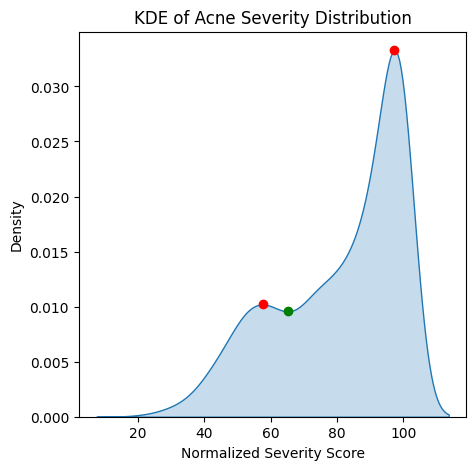

Do you want to view the data? Type Yes or No. No


Ok, going on to modeling.
initial parameters {'r_growth': 0.5, 'K_CC': 1.0, 'k_antibiotics': 0.2, 'k_sebum': 0.01, 'I_bacterial_induction': 0.15, 'I_decay_tstd': 0.35, 'I_baseline_decay': 0.3, 'r_I_production': 0.1, 'r_cream_clean': 0.125, 'noise': 0.01, 'w_sigma': 0.3, 'm_sigma': 0.5}
converged model parameters {'r_growth': np.float64(1.0000000000000002), 'I_bacterial_induction': np.float64(0.23507880642851897), 'I_decay_tstd': np.float64(0.09210340871976183), 'I_baseline_decay': np.float64(0.09210340871976185), 'k_sebum': np.float64(0.1842068174395237), 'k_antibiotics': np.float64(0.1842068174395237), 'r_cream_clean': np.float64(0.20734355039505514), 'K_CC': 1.0}


In [7]:
from acne_model.raw_data_analysis import data_parsing
from acne_model.data_viz import data_visualization
from acne_model.model import model_building
import json
import numpy as np

def main(this_raw_data_name, json_name):
    data_returns = data_parsing(this_raw_data_name)
    these_ranges = data_returns[3]
    these_averages = data_returns[5]
    these_dirichlets = data_returns[6]
    view_plots = False
    user_input = input("Do you want to view the data? Type Yes or No.")
    
    if user_input == "Yes":
         view_plots = True
    if view_plots:
        
        this_data_visualization = data_visualization(data_returns[1], data_returns[0], data_returns[4], data_returns[3])
    if not view_plots:
        print("Ok, going on to modeling.")
        
    with open(json_name, "r") as icgs:
        initial_constant_guesses = json.load(icgs)
        this_model_config = {"scoring": np.random.randn(3, 3) * 0.02,
                        #column order: low severity change, medium, high. row order: #bacteria, inflammation, sebum.
    "biases": [0, 0, 0],
    "Q": np.eye(3) * (initial_constant_guesses["w_sigma"]**2),
    "R": np.eye(3) * (initial_constant_guesses["m_sigma"]**2)}
           
    #reparameterization and the reverse are both done in the function itself now
    this_built_model = model_building(data_returns[1], initial_constant_guesses, these_dirichlets, these_averages, this_model_config)  
    
#retrieving Acne04 dataset from Kaggle source (local download on machine)
this_raw_data_name = "sim_acne.csv"
if __name__ == "__main__":
    main(this_raw_data_name, "initial_constants.json")